<h1>Jamaica Stock Exchange Analysis  </h1>
<p> Basic anslysis data sciences information </p>
<ul> 
<li> Calculate Simple Rate of Return </li>
<li> Stock Risk calculation
<li> Adjustment of split stocks 2015-2018</li>
<li> Adjust for dividends to stock analysis </li>    
<li> Bollinger Band to stock analysis </li>        
<li> Calculate Rate of Return for Portfolio </li>
<li> Calculate Risk Variance for Portfolio </li>
<li> Sharpe stocks Calculation</li>
<li> JSE-Index vs Price Regression on stocks </li>
<li> Markowitz Portfolio effeciency </li>
<li> CAPM - Capital Asset Pricing Model </li>
</ul>
<p><b> #Todo </b><i>Predictive Model</i></p>
<p><b> #Todo </b><i>MACDs</i></p>


<p>&copy; 2018 Romayne Whyte (Ijasoft) <p>


In [85]:
import pandas as pd
import numpy as np
import os
import datetime 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy import linalg
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
%matplotlib inline

<h2>Pulling Informtion from CSV Files</h2>

In [86]:
#Pull the valid stock information
slist = []
folder = 'project'
filelist = os.listdir('c:/'+folder+'/stockcsv/')
for filename in filelist:
    slist.append(pd.read_csv('c:/'+folder+'/stockcsv/'+filename))
    
frame = pd.concat(slist, axis = 0, ignore_index = True)
frame = frame.sort_values(by='Date')
frame.head()

,Symbol,Date,52 Week High,52 Week Low,Previous Year Div,Current Year Div,Volume (non block),Today High,Today Low,Last Traded,Close Price,Price Change,Closing Bid,Closing Ask
164604,PJAM,1/10/2018,45.0000,26.5000,1.05,NaN,73255.0,42.00,41.00,41.00000,41.41000,-0.09,41.00,41.50
164603,PBS9.75,1/10/2018,105.0000,100.0000,NaN,NaN,0.0,0.00,0.00,105.00000,104.45000,0.00,0.00,103.00
164602,PBS,1/10/2018,0.7200,0.5500,NaN,NaN,1500.0,0.55,0.55,0.55000,0.55000,-0.02,0.55,0.57
164601,PAL,1/10/2018,560.0000,200.0000,1.00,NaN,0.0,0.00,0.00,560.00000,560.00000,0.00,300.00,560.00
164600,NCBFGFR2021,1/10/2018,131.5884,131.2217,NaN,NaN,0.0,0.00,0.00,132.01982,132.01982,0.00,0.00,0.00


In [87]:
#Pull the list of delisted to remove from stock frame
framevalid = pd.read_csv('c:/'+folder+'/stockdelist/stockvalid.csv')
framevalid = framevalid.rename(columns={'Instrument Code': 'Symbol'})
framevalid.head()

,Name,Symbol,Currency,Sector,Type,Website
0,138 STUDENT LIVING JAMAICA LIMITED,138SL,JMD,OTHER,ORDINARY,-
1,138 STUDENT LIVING JAMAICA LIMITED VARIABLE PR...,138SLVR,JMD,OTHER,PREFERENCE,-
2,1834 INVESTMENTS LIMITED,1834,JMD,COMMUNICATIONS,ORDINARY,Website
3,BARITA INVESTMENTS LIMITED,BIL,JMD,FINANCE,ORDINARY,Website
4,BERGER PAINTS JAMAICA LTD.,BRG,JMD,MANUFACTURING,ORDINARY,Website


In [88]:
slist = []
slist.append(pd.read_csv('c:/'+folder+'/stocksplit/corporate-actions (1).csv'))
slist.append(pd.read_csv('c:/'+folder+'/stocksplit/corporate-actions (2).csv'))
slist.append(pd.read_csv('c:/'+folder+'/stocksplit/corporate-actions (3).csv'))
slist.append(pd.read_csv('c:/'+folder+'/stocksplit/corporate-actions (4).csv'))
df_info = pd.concat(slist, axis = 0, ignore_index = True)
df_info.head()

,Symbol,Record Date,Action,Dividend Amount,Ex-Date,Payment Date
0,EPLY,12/4/2018,NaN,0.037200,12/3/2018,12/18/2018
1,1834,12/3/2018,NaN,0.100000,11/30/2018,12/19/2018
2,JMMBGL7.50,11/30/2018,NaN,0.004635,11/29/2018,12/14/2018
3,JMMBGL7.25,11/30/2018,NaN,0.006953,11/29/2018,12/14/2018
4,SIL,11/27/2018,Stock Split,5.000000,11/26/2018,NaN


In [89]:
#Pull the valid stock Indicies

slist = []
filelist = os.listdir('c:/'+folder+'/stockindicies/')
for filename in filelist:
    slist.append(pd.read_csv('c:/'+folder+'/stockindicies/'+filename))
    
stkindices_frame = pd.concat(slist, axis = 0, ignore_index = True)
stkindices_frame = stkindices_frame.dropna(axis=0)
stkindices_frame.head()

,Index,Date,Value,Change ($),Change (%),Volume Traded
0,Combined-Index,2017-01-03,206552.15,1592.05,0.78,7228125.0
1,JSE-Index,2017-01-03,194129.75,1853.11,0.96,6933316.0
2,All-Jamaican,2017-01-03,212211.90,2072.41,0.99,6555316.0
3,JSE-Select,2017-01-03,6493.43,89.66,1.40,4924157.0
5,JSE-Junior,2017-01-03,2581.42,-12.29,-0.47,294809.0


<h2>Time for Clean Up</h2>

In [90]:
stkindices_frame = stkindices_frame.drop(['Change ($)','Change (%)','Volume Traded'],axis=1)
stkindices_frame['Date'] = pd.to_datetime(stkindices_frame['Date'])

In [91]:
#split the indicies by index
gp_index = stkindices_frame.groupby("Index")
stk_indicies_list = [gp_index.get_group(x) for x in gp_index.groups]

df_ind_data = pd.DataFrame()
for idx, index in enumerate(stk_indicies_list):
    stk_indicies_list[idx] = stk_indicies_list[idx].set_index('Date')
    df_ind_data[index['Index'].iloc[0]] = stk_indicies_list[idx]['Value']

df_ind_data = df_ind_data.sort_index(axis=0)
df_ind_data.head()

,All-Jamaican,Combined-Index,Cross-Listed,JSE-Index,JSE-Junior,JSE-Select,US-Equities
Date,,,,,,,
2010-01-05,71100.38,NaN,962.92,83386.18,NaN,1902.95,NaN
2010-01-06,70733.92,NaN,962.92,83161.22,150.01,1885.31,NaN
2010-01-07,70335.37,NaN,960.42,82813.36,150.01,1864.57,NaN
2010-01-08,70504.66,NaN,960.42,82917.28,150.01,1870.74,NaN
2010-01-11,70268.72,NaN,960.42,82772.44,150.01,1862.06,NaN


In [92]:
frame = frame.rename(columns={'Close Price': 'Close'})
frame.head()

,Symbol,Date,52 Week High,52 Week Low,Previous Year Div,Current Year Div,Volume (non block),Today High,Today Low,Last Traded,Close,Price Change,Closing Bid,Closing Ask
164604,PJAM,1/10/2018,45.0000,26.5000,1.05,NaN,73255.0,42.00,41.00,41.00000,41.41000,-0.09,41.00,41.50
164603,PBS9.75,1/10/2018,105.0000,100.0000,NaN,NaN,0.0,0.00,0.00,105.00000,104.45000,0.00,0.00,103.00
164602,PBS,1/10/2018,0.7200,0.5500,NaN,NaN,1500.0,0.55,0.55,0.55000,0.55000,-0.02,0.55,0.57
164601,PAL,1/10/2018,560.0000,200.0000,1.00,NaN,0.0,0.00,0.00,560.00000,560.00000,0.00,300.00,560.00
164600,NCBFGFR2021,1/10/2018,131.5884,131.2217,NaN,NaN,0.0,0.00,0.00,132.01982,132.01982,0.00,0.00,0.00


In [93]:
framevalid = framevalid[framevalid.Type == "ORDINARY"]
framevalid.head()

,Name,Symbol,Currency,Sector,Type,Website
0,138 STUDENT LIVING JAMAICA LIMITED,138SL,JMD,OTHER,ORDINARY,-
2,1834 INVESTMENTS LIMITED,1834,JMD,COMMUNICATIONS,ORDINARY,Website
3,BARITA INVESTMENTS LIMITED,BIL,JMD,FINANCE,ORDINARY,Website
4,BERGER PAINTS JAMAICA LTD.,BRG,JMD,MANUFACTURING,ORDINARY,Website
6,CARIBBEAN CEMENT COMPANY LTD.,CCC,JMD,MANUFACTURING,ORDINARY,Website


In [94]:
#Remove unnecessary columns
frame = frame.drop(['52 Week High','52 Week Low','Current Year Div','Today High','Today Low','Last Traded','Price Change','Closing Bid','Closing Ask','Previous Year Div','Volume (non block)'],axis=1)
frame.head()

,Symbol,Date,Close
164604,PJAM,1/10/2018,41.41000
164603,PBS9.75,1/10/2018,104.45000
164602,PBS,1/10/2018,0.55000
164601,PAL,1/10/2018,560.00000
164600,NCBFGFR2021,1/10/2018,132.01982


In [95]:
#filter for only the valid stocks
frame = frame[frame["Symbol"].isin(framevalid["Symbol"].tolist())]
frame.head()

,Symbol,Date,Close
164604,PJAM,1/10/2018,41.41
164601,PAL,1/10/2018,560.00
164599,NCBFG,1/10/2018,99.63
164598,MUSIC,1/10/2018,0.53
164596,MIL,1/10/2018,7.38


In [96]:

frame['Date'] = pd.to_datetime(frame['Date'])
frame.head()

,Symbol,Date,Close
164604,PJAM,2018-01-10,41.41
164601,PAL,2018-01-10,560.00
164599,NCBFG,2018-01-10,99.63
164598,MUSIC,2018-01-10,0.53
164596,MIL,2018-01-10,7.38


In [97]:
#Extract the Split Information from the Info dataframe
df_info["Action"] = df_info["Action"].str.strip()
df_split = df_info[df_info["Action"]=='Stock Split']
df_split = df_split.drop(['Record Date','Action','Payment Date'],axis=1)
df_split['Ex-Date'] = pd.to_datetime(df_split['Ex-Date'])
df_split = df_split.dropna(axis=0,how='any')
df_split

,Symbol,Dividend Amount,Ex-Date
4,SIL,5.0,2018-11-26
57,DTL,10.0,2018-09-05
65,BPOW,10.0,2018-08-28
269,CAR,10.0,2017-09-18
323,PULS,5.0,2017-07-03
336,JETCON,4.0,2017-06-22
355,KEX,5.0,2017-05-31
362,KPREIT,2.0,2017-05-19
384,JAMT,2.0,2017-04-18
409,AMG,5.0,2017-03-10


In [98]:
#Extract the Dividend from the Info Dataframe
df_info["Action"] = df_info["Action"].str.strip()
df_div = df_info[df_info["Action"]!='Stock Split']
df_div = df_info.drop(['Action','Record Date','Payment Date'],axis=1)
df_div['Ex-Date'] = pd.to_datetime(df_div['Ex-Date'])
df_div = df_div.dropna(axis=0,how='any')

In [99]:
df_div.head()

,Symbol,Dividend Amount,Ex-Date
0,EPLY,0.037200,2018-12-03
1,1834,0.100000,2018-11-30
2,JMMBGL7.50,0.004635,2018-11-29
3,JMMBGL7.25,0.006953,2018-11-29
4,SIL,5.000000,2018-11-26


In [100]:
df_div.tail()

,Symbol,Dividend Amount,Ex-Date
865,JMMB7.5,0.0127,2015-01-16
866,EPLY9.5,0.0484,2015-01-16
867,BIL,0.0700,2015-01-08
868,KW,0.1000,2015-01-07
869,HL,0.3200,2015-01-05


In [101]:
#Fix the stock Split Issues
frame['split'] = 1.0#np.nan
frame['dividend'] = 0.00 #np.nan
frame.head()

,Symbol,Date,Close,split,dividend
164604,PJAM,2018-01-10,41.41,1.0,0.0
164601,PAL,2018-01-10,560.00,1.0,0.0
164599,NCBFG,2018-01-10,99.63,1.0,0.0
164598,MUSIC,2018-01-10,0.53,1.0,0.0
164596,MIL,2018-01-10,7.38,1.0,0.0


In [102]:
#Remove Duplicated stock price
frame = frame.drop_duplicates(subset = ["Symbol","Date"], keep=False)

In [103]:
#Can be used to check for duplication but will raise error of no duplication 
#pd.concat(g for _, g in frame.groupby(["Symbol","Date"]) if len(g) > 1)

In [104]:
gp = frame.groupby("Symbol")

In [105]:
stklist = [gp.get_group(x) for x in gp.groups]

# swap CAR with 138SL
temp = stklist[0]
stklist[0] = stklist[10]
stklist[10] = temp

In [106]:
for idx, stk in enumerate(stklist):
    stklist[idx] = stklist[idx].set_index('Date')

stklist[0].head()

,Symbol,Close,split,dividend
Date,,,,
2018-01-10,CCC,34.10,1.0,0.0
2018-01-11,CCC,33.26,1.0,0.0
2018-01-12,CCC,33.26,1.0,0.0
2018-01-15,CCC,33.26,1.0,0.0
2018-01-16,CCC,33.62,1.0,0.0


In [107]:
#Assign the split values per symbol and date from split dataframe to the stock dataframe
for idx, stk in enumerate(stklist):    
    symbol = stk['Symbol'][0]
    if not df_split[(df_split.Symbol == symbol)].empty:
        split_s = df_split[(df_split.Symbol == symbol)]        
        stk.at[split_s['Ex-Date'].iloc[0],'split'] = split_s['Dividend Amount'].iloc[0]
        print(stk[stk.index.isin(split_s['Ex-Date'].tolist())])
        stklist[idx] = stk                

           Symbol  Close  split  dividend
Date                                     
2017-03-10    AMG   4.87    5.0       0.0
           Symbol  Close  split  dividend
Date                                     
2018-08-28   BPOW    4.7   10.0       0.0
           Symbol  Close  split  dividend
Date                                     
2017-09-18    CAR  10.87   10.0       0.0
           Symbol  Close  split  dividend
Date                                     
2018-09-05    DTL   2.65   10.0       0.0
           Symbol  Close  split  dividend
Date                                     
2017-04-18   JAMT   3.67    2.0       0.0
            Symbol  Close  split  dividend
Date                                      
2017-06-22  JETCON   5.66    4.0       0.0
           Symbol  Close  split  dividend
Date                                     
2017-05-31    KEX   15.0    5.0       0.0
            Symbol  Close  split  dividend
Date                                      
2017-05-19  KPREIT    8.3    

In [108]:
#Assign the dividend values per symbol and date from info dataframe to the stock dataframe
for idx, stk in enumerate(stklist):    
    symbol = stk['Symbol'][0]
    if not df_div[(df_div.Symbol == symbol)].empty:
        div_s = df_div[(df_div.Symbol == symbol)]
        for ds in div_s.values:            
            stk.at[ds[2],'dividend'] = ds[1]        
        
        stklist[idx] = stk  

stklist[0].head()

,Symbol,Close,split,dividend
Date,,,,
2018-01-10,CCC,34.10,1.0,0.0
2018-01-11,CCC,33.26,1.0,0.0
2018-01-12,CCC,33.26,1.0,0.0
2018-01-15,CCC,33.26,1.0,0.0
2018-01-16,CCC,33.62,1.0,0.0


In [109]:
# https://joshschertz.com/2016/08/27/Vectorizing-Adjusted-Close-with-Python/
def calculate_adjusted_prices(df, column):
    """ Vectorized approach for calculating the adjusted prices for the
    specified column in the provided DataFrame. This creates a new column
    called 'adj_<column name>' with the adjusted prices. This function requires
    that the DataFrame have columns with dividend and split_ratio values.

    :param df: DataFrame with raw prices along with dividend and split_ratio
        values
    :param column: String of which price column should have adjusted prices
        created for it
    :return: DataFrame with the addition of the adjusted price column
    """
    adj_column = 'adj_' + column + '_Check'

    # Reverse the DataFrame order, sorting by date in descending order
    df.sort_index(ascending=False, inplace=True)

    price_col = df[column].values
    split_col = df['split'].values
    dividend_col = df['dividend'].values
    adj_price_col = np.zeros(len(df.index))
    adj_price_col[0] = price_col[0]
          
    for i in range(1, len(price_col)):
        adj_price_col[i] = round((adj_price_col[i - 1] + adj_price_col[i - 1] *
                   (((price_col[i] * (1/split_col[i - 1])) -
                     price_col[i - 1]) / price_col[i - 1])), 4)

    df[adj_column] = adj_price_col

    # Change the DataFrame order back to dates ascending
    df.sort_index(ascending=True, inplace=True)

    return df

In [110]:
for idx, stk in enumerate(stklist):        
    stklist[idx] = calculate_adjusted_prices(stklist[idx],'Close')

stklist[0].head()

,Symbol,Close,split,dividend,adj_Close_Check
Date,,,,,
2008-01-02,CCC,9.50,1.0,0.0,9.50
2008-01-03,CCC,10.00,1.0,0.0,10.00
2008-01-04,CCC,10.00,1.0,0.0,10.00
2008-01-07,CCC,10.00,1.0,0.0,10.00
2008-01-08,CCC,10.45,1.0,0.0,10.45


In [111]:
stkframe = pd.DataFrame()
for stk in stklist:
    stkframe[stk['Symbol'][0]] = stk['adj_Close_Check']

In [112]:
stkframe.head()

,CCC,1834,AFS,AMG,BIL,BPOW,BRG,CAC,CAR,CBNY,...,SJ,SML,SOS,SRA,SSLVC,SVL,TTECH,VMIL,WISYNCO,XFUND
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-02,9.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.40,NaN,NaN,NaN,NaN
2008-01-03,10.00,4.19,NaN,NaN,NaN,NaN,NaN,NaN,7.101,NaN,...,NaN,NaN,NaN,NaN,NaN,2.75,NaN,NaN,NaN,NaN
2008-01-04,10.00,4.05,NaN,NaN,NaN,NaN,3.02,NaN,7.800,0.01,...,NaN,NaN,NaN,NaN,NaN,2.75,NaN,NaN,NaN,NaN
2008-01-07,10.00,4.00,NaN,NaN,NaN,NaN,3.05,NaN,7.799,NaN,...,NaN,NaN,NaN,NaN,NaN,2.51,NaN,NaN,NaN,NaN
2008-01-08,10.45,4.00,NaN,NaN,NaN,NaN,3.05,NaN,7.400,NaN,...,NaN,NaN,NaN,NaN,NaN,2.80,NaN,NaN,NaN,NaN


In [113]:
stkframe.tail()

,CCC,1834,AFS,AMG,BIL,BPOW,BRG,CAC,CAR,CBNY,...,SJ,SML,SOS,SRA,SSLVC,SVL,TTECH,VMIL,WISYNCO,XFUND
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-17,43.20,1.12,50.50,1.70,32.57,6.25,23.20,16.9,9.46,0.12,...,41.05,4.60,8.50,3.5,2.00,15.70,5.29,3.60,10.37,10.59
2018-12-18,39.79,1.10,48.95,1.70,33.18,6.25,19.72,16.9,9.31,0.12,...,40.21,4.20,8.10,3.5,2.00,15.51,5.29,3.52,10.51,10.09
2018-12-19,41.43,1.15,48.95,1.68,33.96,6.20,19.90,16.9,9.32,0.12,...,40.02,4.72,8.10,3.5,1.90,15.53,5.29,3.57,10.52,10.01
2018-12-20,42.91,1.15,47.70,1.85,36.34,6.20,20.46,16.9,9.38,0.12,...,39.83,5.00,8.67,3.5,1.90,15.56,5.29,3.55,10.40,10.02
2018-12-21,44.57,1.15,50.24,1.85,40.91,6.20,22.00,16.9,9.31,0.12,...,38.62,5.00,8.67,3.5,1.95,14.92,5.29,3.61,10.42,10.20


In [114]:
divframe = pd.DataFrame()
for div in stklist:
    divframe[div['Symbol'][0]] = div['dividend']

In [115]:
divframe.head()

,CCC,1834,AFS,AMG,BIL,BPOW,BRG,CAC,CAR,CBNY,...,SJ,SML,SOS,SRA,SSLVC,SVL,TTECH,VMIL,WISYNCO,XFUND
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-02,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2008-01-03,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2008-01-04,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2008-01-07,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2008-01-08,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [116]:
divframe[divframe['SCIJMD'] > 0]['SCIJMD']

Series([], Name: SCIJMD, dtype: float64)

<h2> Filter the data to a Time Range </h2>
<p> This Allows to specify the time range analyse stocks </p>

In [117]:
#filter the data for the 01 January 2018 to 31 December, 2018

startdate = '2016-01-01'
enddate = '2018-12-31'

stkframe=stkframe[startdate:enddate]
divframe = divframe[startdate:enddate]
df_ind_data = df_ind_data[startdate:enddate]

In [118]:
stkframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 746 entries, 2016-01-04 to 2018-12-21
Data columns (total 73 columns):
CCC         746 non-null float64
1834        746 non-null float64
AFS         746 non-null float64
AMG         746 non-null float64
BIL         746 non-null float64
BPOW        746 non-null float64
BRG         746 non-null float64
CAC         744 non-null float64
CAR         746 non-null float64
CBNY        746 non-null float64
138SL       746 non-null float64
CFF         746 non-null float64
CHL         746 non-null float64
CPJ         746 non-null float64
DCOVE       746 non-null float64
DTL         746 non-null float64
ECL         358 non-null float64
EFRESH      128 non-null float64
ELITE       213 non-null float64
EPLY        746 non-null float64
FOSRICH     252 non-null float64
GENAC       746 non-null float64
GK          746 non-null float64
GWEST       252 non-null float64
HONBUN      746 non-null float64
INDIES      92 non-null float64
ISP         688 non

In [119]:
stkframe.head()

,CCC,1834,AFS,AMG,BIL,BPOW,BRG,CAC,CAR,CBNY,...,SJ,SML,SOS,SRA,SSLVC,SVL,TTECH,VMIL,WISYNCO,XFUND
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,20.15,1.70,16.00,1.400,3.8,1.31,3.19,NaN,6.011,0.21,...,20.00,NaN,NaN,3.91,NaN,4.66,NaN,NaN,NaN,11.00
2016-01-05,19.50,1.98,16.06,1.440,3.8,1.31,3.12,NaN,6.104,0.21,...,20.51,NaN,NaN,3.91,NaN,4.65,NaN,NaN,NaN,11.00
2016-01-06,20.24,2.50,16.06,1.472,3.8,1.31,3.15,4.89,6.061,0.26,...,21.83,NaN,NaN,3.91,NaN,4.66,2.50,NaN,NaN,11.00
2016-01-07,20.87,2.71,16.00,1.472,3.8,1.31,3.69,5.35,6.049,0.24,...,22.08,NaN,NaN,3.91,NaN,4.66,3.05,NaN,NaN,10.27
2016-01-08,22.03,2.63,16.00,1.810,3.8,1.31,3.31,5.60,6.015,0.25,...,22.76,NaN,NaN,3.91,NaN,4.66,3.60,NaN,NaN,11.10


In [120]:
stkframe.tail()

,CCC,1834,AFS,AMG,BIL,BPOW,BRG,CAC,CAR,CBNY,...,SJ,SML,SOS,SRA,SSLVC,SVL,TTECH,VMIL,WISYNCO,XFUND
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-17,43.20,1.12,50.50,1.70,32.57,6.25,23.20,16.9,9.46,0.12,...,41.05,4.60,8.50,3.5,2.00,15.70,5.29,3.60,10.37,10.59
2018-12-18,39.79,1.10,48.95,1.70,33.18,6.25,19.72,16.9,9.31,0.12,...,40.21,4.20,8.10,3.5,2.00,15.51,5.29,3.52,10.51,10.09
2018-12-19,41.43,1.15,48.95,1.68,33.96,6.20,19.90,16.9,9.32,0.12,...,40.02,4.72,8.10,3.5,1.90,15.53,5.29,3.57,10.52,10.01
2018-12-20,42.91,1.15,47.70,1.85,36.34,6.20,20.46,16.9,9.38,0.12,...,39.83,5.00,8.67,3.5,1.90,15.56,5.29,3.55,10.40,10.02
2018-12-21,44.57,1.15,50.24,1.85,40.91,6.20,22.00,16.9,9.31,0.12,...,38.62,5.00,8.67,3.5,1.95,14.92,5.29,3.61,10.42,10.20


In [121]:
#filter the data for the 01 January 2018 to 03 December, 2018
#df_ind_data=df_ind_data['2018-01-01': '2018-11-31']

df_ind_data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 748 entries, 2016-01-04 to 2018-12-21
Data columns (total 7 columns):
All-Jamaican      748 non-null float64
Combined-Index    748 non-null float64
Cross-Listed      34 non-null float64
JSE-Index         748 non-null float64
JSE-Junior        748 non-null float64
JSE-Select        748 non-null float64
US-Equities       723 non-null float64
dtypes: float64(7)
memory usage: 46.8 KB


<h2>Time for Some Financial Analysis</h2>

<h3> Analysis for the indicies <h3>

In [122]:
#Jamica Indices Return 
ind_returns = np.log(df_ind_data / df_ind_data.shift(1)) 
ind_returns.head()

,All-Jamaican,Combined-Index,Cross-Listed,JSE-Index,JSE-Junior,JSE-Select,US-Equities
Date,,,,,,,
2016-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,0.001425,0.002626,NaN,0.001416,0.013241,0.008400,0.002031
2016-01-06,0.016895,0.015516,NaN,0.016792,0.004314,0.018440,-0.000369
2016-01-07,0.018301,0.020583,NaN,0.018191,0.041194,0.025574,-0.003326
2016-01-08,-0.002315,0.007075,NaN,-0.002301,0.083584,0.011902,-0.016674


In [123]:
ind_returns.tail()

,All-Jamaican,Combined-Index,Cross-Listed,JSE-Index,JSE-Junior,JSE-Select,US-Equities
Date,,,,,,,
2018-12-17,-0.010444,-0.009487,NaN,-0.010444,0.000122,-0.001696,-0.001979
2018-12-18,-0.002642,-0.001116,NaN,-0.002642,0.013994,-0.015352,0.030628
2018-12-19,-0.002825,-0.002303,NaN,-0.002825,0.002812,-0.010404,0.000000
2018-12-20,0.003972,0.002869,NaN,0.003972,-0.007962,0.012798,-0.023329
2018-12-21,0.000287,0.002206,NaN,0.000287,0.020980,-0.003128,-0.079427


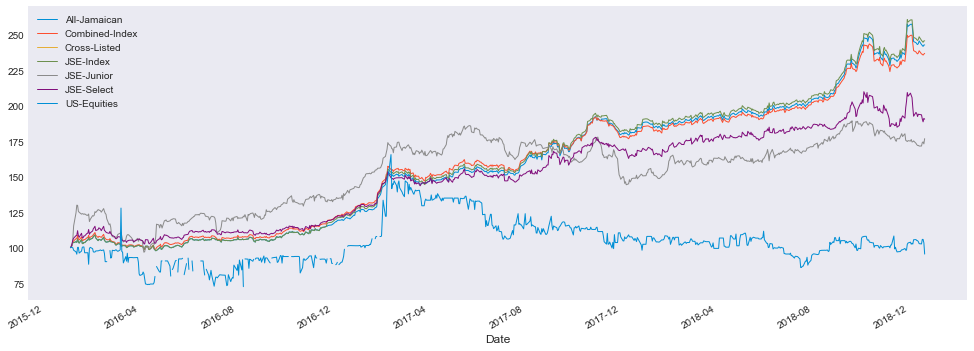

In [124]:
indicesplot = ((df_ind_data / df_ind_data.iloc[0]) * 100)
indicesplot.sort_index(axis=0).head()
indicesplot.plot(figsize=(15, 6),linewidth=1);
#plt.rcParams.update({'font.size': 12})
#(df_ind_data / df_ind_data.iloc[0] * 100).plot(figsize=(15, 6));
plt.show()


In [125]:
#indicies Annual Rate of Return
annual_ind_returns = ind_returns.apply(lambda x: (x.mean()*250) if  x.count() > 250 else (x.mean() * x.count())) 
#annual_ind_returns = ind_returns.mean() * ind_returns.count()
round(annual_ind_returns[:] * 100,5)

All-Jamaican      29.68564
Combined-Index    28.85686
Cross-Listed      -4.87890
JSE-Index         30.08294
JSE-Junior        19.06488
JSE-Select        21.56204
US-Equities      -19.50965
dtype: float64

<h3> Analysis for Jamaia Stocks </h3>

In [126]:
# This is simple rate of returns 
#rate_return = (stkframe/stkframe.shift(1))-1
# same as 
#rate_return = stkframe.pct_change()

# This is simple rate of returns with dividends involved
#rate_return = ((stkframe+divframe)/stkframe.shift(1))-1

# This is rate of returns with log
rate_return_div = np.log((stkframe+divframe)/stkframe.shift(1))
rate_return = np.log(stkframe/stkframe.shift(1))
rate_return = rate_return.replace([np.inf, -np.inf], np.nan)
rate_return.head()

,CCC,1834,AFS,AMG,BIL,BPOW,BRG,CAC,CAR,CBNY,...,SJ,SML,SOS,SRA,SSLVC,SVL,TTECH,VMIL,WISYNCO,XFUND
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,-0.032790,0.152469,0.003743,0.028171,0.0,0.0,-0.022188,NaN,0.015353,0.000000,...,0.025180,NaN,NaN,0.0,NaN,-0.002148,NaN,NaN,NaN,0.000000
2016-01-06,0.037246,0.233194,0.000000,0.021979,0.0,0.0,0.009569,NaN,-0.007069,0.213574,...,0.062373,NaN,NaN,0.0,NaN,0.002148,NaN,NaN,NaN,0.000000
2016-01-07,0.030652,0.080658,-0.003743,0.000000,0.0,0.0,0.158224,0.089904,-0.001982,-0.080043,...,0.011387,NaN,NaN,0.0,NaN,0.000000,0.198851,NaN,NaN,-0.068668
2016-01-08,0.054092,-0.029965,0.000000,0.206705,0.0,0.0,-0.108678,0.045670,-0.005637,0.040822,...,0.030332,NaN,NaN,0.0,NaN,0.000000,0.165792,NaN,NaN,0.077718


In [127]:
rate_return.tail()

,CCC,1834,AFS,AMG,BIL,BPOW,BRG,CAC,CAR,CBNY,...,SJ,SML,SOS,SRA,SSLVC,SVL,TTECH,VMIL,WISYNCO,XFUND
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-17,0.005804,-0.017700,0.000000,0.000000,-0.015235,-0.019018,0.053110,0.0,0.013837,0.0,...,-0.004860,-0.015103,0.048202,0.0,0.000000,-0.007614,0.019085,0.011173,0.002897,-0.004710
2018-12-18,-0.082225,-0.018019,-0.031174,0.000000,0.018556,0.000000,-0.162519,0.0,-0.015983,0.0,...,-0.020675,-0.090972,-0.048202,0.0,0.000000,-0.012176,0.000000,-0.022473,0.013410,-0.048365
2018-12-19,0.040390,0.044452,0.000000,-0.011834,0.023236,-0.008032,0.009086,0.0,0.001074,0.0,...,-0.004736,0.116724,0.000000,0.0,-0.051293,0.001289,0.000000,0.014105,0.000951,-0.007960
2018-12-20,0.035100,0.000000,-0.025868,0.096392,0.067736,0.000000,0.027752,0.0,0.006417,0.0,...,-0.004759,0.057629,0.068005,0.0,0.000000,0.001930,0.000000,-0.005618,-0.011472,0.000999
2018-12-21,0.037956,0.000000,0.051880,0.000000,0.118455,0.000000,0.072571,0.0,-0.007491,0.0,...,-0.030850,0.000000,0.000000,0.0,0.025975,-0.042001,0.000000,0.016760,0.001921,0.017805


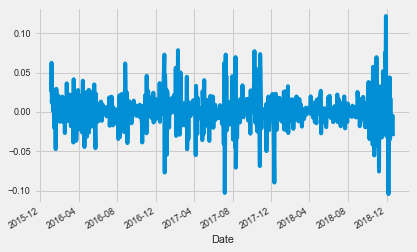

<Figure size 2400x2000 with 0 Axes>

In [225]:
#Sample of rate of return
sym = 'SJ'

rate_return[sym].plot()
plt.figure(figsize=(30,25), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 10})
plt.show()

[]

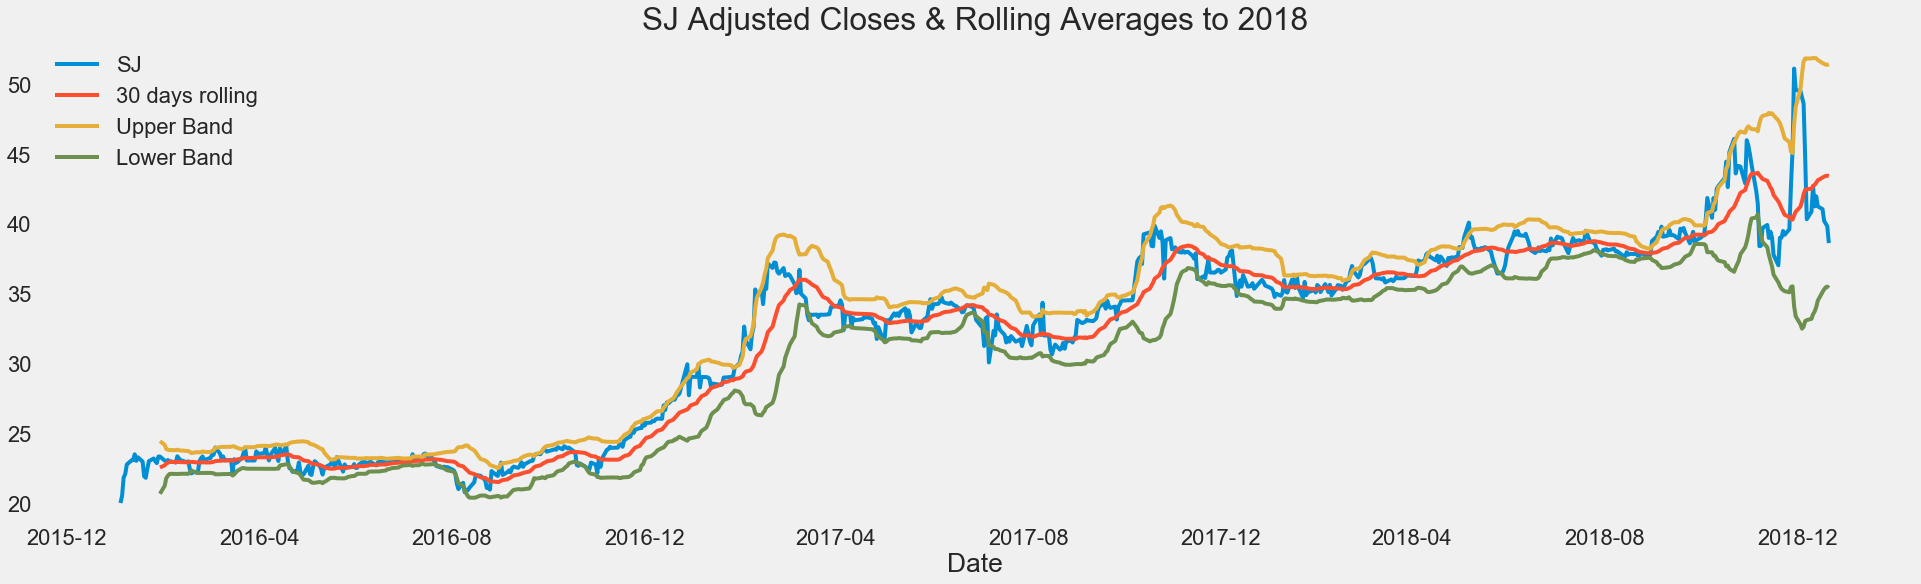

In [226]:




df_closing = stkframe[sym]
df_30days = df_closing.rolling(window=20).mean()
df_30std = df_closing.rolling(window=20).std()
df_upperband = df_30days + (df_30std * 2)
df_lowerband = df_30days - (df_30std * 2)

#df_30days = df_closing.rolling( 30 ).mean()
#df_expand = df_closing.expanding().mean()
#df_ewm = df_closing.ewm(alpha=0.03).mean()

fig = plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
fig.autofmt_xdate()
ax = fig.add_subplot(1,1,1)
ax.plot(df_closing.index, df_closing, label=sym)
ax.plot(df_30days.index, df_30days, label='30 days rolling') #simple moving average
ax.plot(df_upperband.index, df_upperband, label='Upper Band') #simple moving average
ax.plot(df_lowerband.index, df_lowerband, label='Lower Band') #simple moving average


#ax.plot(df_30days.index, df_30days, label='30 days rolling') #simple moving average
#ax.plot(df_expand.index, df_30days, label='Expanding Average')
#ax.plot(df_ewm.index, df_ewm, label='EWMA($\\alpha=.03$)') # Exponentially weighted moving average

ax.grid()
ax.legend(loc=0)
ax.set_xlabel('Date')
plt.title(sym+' Adjusted Closes & Rolling Averages to 2018')
plt.plot()

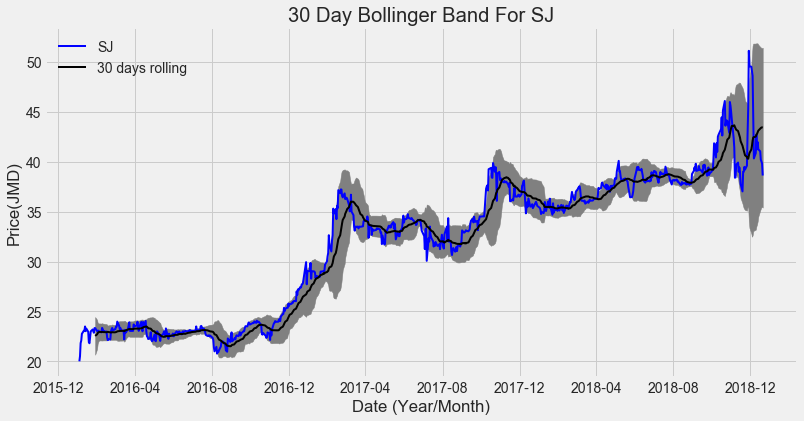

In [227]:
# set style, empty figure and axes
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

# Get index values for the X axis for facebook DataFrame
x_axis = df_closing.index.get_level_values(0)

# Plot shaded 21 Day Bollinger Band for Facebook
ax.fill_between(x_axis, df_upperband, df_lowerband, color='grey')

# Plot Adjust Closing Price and Moving Averages
ax.plot(x_axis, df_closing, color='blue', lw=2)
ax.plot(x_axis, df_30days, color='black',label='30 days rolling', lw=2)

# Set Title & Show the Image
ax.set_title('30 Day Bollinger Band For '+ sym)
ax.set_xlabel('Date (Year/Month)')
ax.set_ylabel('Price(JMD)')
ax.legend()
plt.show();

In [228]:
rate_return[sym].dropna().head(),rate_return[sym].tail()

(Date
 2016-01-05    0.025180
 2016-01-06    0.062373
 2016-01-07    0.011387
 2016-01-08    0.030332
 2016-01-11    0.013095
 Name: SJ, dtype: float64, Date
 2018-12-17   -0.004860
 2018-12-18   -0.020675
 2018-12-19   -0.004736
 2018-12-20   -0.004759
 2018-12-21   -0.030850
 Name: SJ, dtype: float64)

In [229]:
stkframe[sym].dropna().head(),stkframe[sym].tail()

(Date
 2016-01-04    20.00
 2016-01-05    20.51
 2016-01-06    21.83
 2016-01-07    22.08
 2016-01-08    22.76
 Name: SJ, dtype: float64, Date
 2018-12-17    41.05
 2018-12-18    40.21
 2018-12-19    40.02
 2018-12-20    39.83
 2018-12-21    38.62
 Name: SJ, dtype: float64)

In [230]:

#Calculate the Average Rate of Return

avg_returns = rate_return_div.apply(lambda x: (x.mean()*250) if  x.count() > 250 else (x.mean() * x.count()))

# Drop all records with no application
avg_returns = avg_returns.dropna()
# Drop all record with 0 as rate of return
#avg_returns = avg_returns.drop(avg_returns[avg_returns == 0].index)
round(avg_returns[avg_returns > 0].sort_values(),5)*100

CPJ           0.526000
DCOVE         4.848000
CBNY          4.986000
MJE           5.157000
WISYNCO       5.756000
PURITY        8.383000
LASF          9.081000
SSLVC        10.821000
KREMI        10.966000
VMIL         14.579000
ProvenJA     14.754000
SEP          19.051000
KLE          20.062000
KEY          21.013000
GENAC        22.551000
MDS          23.010000
SGJ          24.696000
KPREIT       25.122000
TTECH        25.709000
SJ           25.876000
CCC          26.639000
CFF          26.937000
MIL          28.512000
FOSRICH      29.730000
JAMT         29.804000
JBG          36.439000
ELITE        38.866000
AMG          39.896000
AFS          40.977000
JMMBGL       42.377000
CAC          42.868000
SIL          43.068000
SVL          44.847000
SALF         48.065000
NCBFG        49.807000
MUSIC        56.779000
MEEG         60.608000
KW           65.605000
BRG          67.301000
KEX          73.068000
INDIES       75.769000
JETCON       82.439000
BIL          83.538000
ISP        

In [231]:
#find the stocks that have split
round(avg_returns[avg_returns <= 0].sort_values(),5)*100

EPLY     -119.533
GWEST     -58.198
RJR       -48.325
SCIJMD    -47.880
EFRESH    -45.416
PTL       -43.213
CHL       -28.472
JSE       -19.926
SCIJA     -18.349
HONBUN    -17.379
PJX       -15.468
JP        -10.889
LASD      -10.167
SML        -9.531
138SL      -9.171
GK         -8.116
PJAM       -5.931
1834       -5.690
SRA        -3.717
XFUND      -1.685
LASM       -0.671
dtype: float64

<h3> Calculate Stock Return Risk (Standard Deviation) </h3>

In [232]:
stk_std_risk = rate_return.apply(lambda x: (x.std()* 250 ** 0.5 ) if  x.count() > 250 else (x.std() * x.count() ** 0.5))
round(stk_std_risk.sort_values(),5) * 100

SRA          14.907
ProvenJA     16.171
SCIJA        18.349
NCBFG        27.189
MJE          28.652
CAR          28.674
SJ           32.864
138SL        33.904
WISYNCO      34.682
SSLVC        35.386
VMIL         36.557
SML          39.422
SCIJMD       40.690
JBG          40.735
XFUND        44.651
KW           45.541
PJX          47.417
JMMBGL       47.486
SGJ          48.381
INDIES       48.434
DCOVE        48.622
AFS          49.294
KPREIT       50.952
EFRESH       53.568
ROC          53.708
SEP          54.555
CAC          54.957
LASM         55.427
ELITE        55.670
SVL          56.888
             ...   
BRG          67.193
GWEST        67.859
CCC          68.056
1834         70.834
FOSRICH      70.869
BPOW         71.081
TTECH        71.657
KEY          71.907
PAL          72.356
MDS          72.818
DTL          73.136
MUSIC        74.268
JAMT         76.928
MIL          77.387
KLE          78.487
PURITY       80.201
KREMI        80.459
MEEG         84.024
ECL          91.558


<h3> Sharpe Ratio </h3>

In [233]:
bondRiskFreeRate = 0.05
sharpe = (avg_returns - bondRiskFreeRate) / stk_std_risk
sharpe[sharpe > 0].sort_values() 

MJE         0.005476
WISYNCO     0.021802
PURITY      0.042181
LASF        0.063260
KREMI       0.074144
SSLVC       0.164510
KLE         0.191899
KEY         0.222693
MDS         0.247323
SEP         0.257553
VMIL        0.262039
GENAC       0.273186
TTECH       0.288996
MIL         0.303829
CCC         0.317967
JAMT        0.322426
FOSRICH     0.348961
CFF         0.374570
KPREIT      0.394920
SGJ         0.407112
AMG         0.555082
ProvenJA    0.603168
ELITE       0.608334
SIL         0.623998
SJ          0.635220
MEEG        0.661816
CAC         0.689039
MUSIC       0.697183
SVL         0.700443
SALF        0.725323
AFS         0.729857
JBG         0.771791
JMMBGL      0.787115
PULS        0.847769
BRG         0.927203
SOS         1.028283
ECL         1.110882
KEX         1.167140
PAL         1.248448
BIL         1.260647
BPOW        1.291151
JETCON      1.316375
KW          1.330790
ISP         1.364966
INDIES      1.461126
DTL         1.539635
NCBFG       1.647969
CAR         3

In [234]:
sharpe[sharpe <= 0].sort_values() 

SCIJMD   -1.299577
SCIJA    -1.272497
EFRESH   -0.941158
GWEST    -0.931309
SRA      -0.584784
RJR      -0.538723
PJX      -0.431662
EPLY     -0.419539
138SL    -0.417969
SML      -0.368603
PTL      -0.319408
LASD     -0.263070
CHL      -0.239838
JSE      -0.217643
GK       -0.196661
HONBUN   -0.188482
1834     -0.150918
XFUND    -0.149728
JP       -0.133985
PJAM     -0.108446
LASM     -0.102311
CPJ      -0.068421
DCOVE    -0.003125
CBNY     -0.000117
dtype: float64

<h3> Stock Correlation </h3>

In [235]:
rate_with_index = pd.merge(rate_return,ind_returns[['JSE-Index', 'JSE-Junior']],left_index=True,right_index=True)

#Variance of two stocks
rate_with_index[[sym,'JSE-Index']].var() 

SJ           0.000432
JSE-Index    0.000075
dtype: float64

In [236]:
#Annualize the Variance
rate_with_index[[sym,'JSE-Index']].var() * 250

SJ           0.108004
JSE-Index    0.018853
dtype: float64

In [237]:
#Covariance of two stock
rate_with_index[[sym,'JSE-Index']].cov() 

,SJ,JSE-Index
SJ,0.000432,0.000087
JSE-Index,0.000087,0.000075


In [238]:
#Annualize covariance of two stock
rate_with_index[[sym,'JSE-Index']].cov() * 250

,SJ,JSE-Index
SJ,0.108004,0.021665
JSE-Index,0.021665,0.018853


In [239]:
#Correlation of returns of two stock
rate_with_index[[sym,'JSE-Index']].corr()

,SJ,JSE-Index
SJ,1.000000,0.480122
JSE-Index,0.480122,1.000000


<h3> Capital Asset Pricing Model <span>(CAPM)</span>  </h3>

In [240]:
#Calculate the Beta of all stocks
asym = []
abeta = []
for sy in rate_return.T.index:    
    adjrate = rate_with_index[[sy,'JSE-Index']].dropna()
    annual_count = 250 if adjrate[sy].count() > 250 else adjrate[sy].count()    
    cov = adjrate.cov() * annual_count
    var = adjrate['JSE-Index'].var() * annual_count
    beta = cov.iloc[0,1]/var
    
    #rate = rate_with_index[[sy,'JSE-Index']].dropna()
    #x = rate[sy].tolist()
    #y = rate['JSE-Index'].tolist()        
    
    #x = np.reshape(x, (len(x), 1))
    #y = np.reshape(y, (len(y), 1))    
    #x1 = sm.add_constant(x)    
    #model = sm.OLS(y, x1).fit()                
    #beta = model.params[1]
    #(beta,alpha,r_value,p_value,std_err) = stats.linregress(x,y) 
    
    
    
    asym.append(sy)
    abeta.append(beta)


beta_series = pd.Series(np.array(abeta),index=asym)
beta_series[beta_series > 0].sort_values(ascending=False)

SGJ        2.215448
NCBFG      1.204491
SJ         1.149160
CCC        1.107549
JP         0.955086
INDIES     0.918964
JMMBGL     0.801543
1834       0.790556
WISYNCO    0.594729
SVL        0.582937
KW         0.558074
PTL        0.548180
XFUND      0.514924
JBG        0.498565
CHL        0.458369
EFRESH     0.450189
TTECH      0.429616
HONBUN     0.420576
BIL        0.409647
PURITY     0.407547
SSLVC      0.395787
MIL        0.390541
RJR        0.386970
JAMT       0.377609
LASD       0.364592
ECL        0.363990
CBNY       0.349967
CAC        0.343659
PJAM       0.342837
ELITE      0.340714
SEP        0.324714
SCIJMD     0.316593
PAL        0.307687
SML        0.302253
LASF       0.294739
SIL        0.287489
138SL      0.266254
VMIL       0.249011
JETCON     0.246635
LASM       0.246302
KLE        0.235112
CAR        0.224905
GWEST      0.195132
SALF       0.191622
CPJ        0.187999
GK         0.169062
BRG        0.161976
DCOVE      0.150267
KEX        0.141096
KEY        0.128727


In [241]:
beta_series[beta_series < 0].sort_values(ascending=False)

JSE        -0.008085
SCIJA      -0.010017
ProvenJA   -0.012353
KREMI      -0.031199
AFS        -0.032572
AMG        -0.034744
BPOW       -0.042568
KPREIT     -0.062222
CFF        -0.070906
FOSRICH    -0.078999
MJE        -0.083976
EPLY       -0.152969
SOS        -0.393183
dtype: float64

In [242]:
# Pull the Equity Risk Premium for Jamaica
# http://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/ctryprem.html

EquityRiskPremium = 0.126

In [243]:
# This is the CAPM for stock
round((bondRiskFreeRate + beta_series * EquityRiskPremium) * 100,4)

CCC         18.9551
1834        14.9610
AFS          4.5896
AMG          4.5622
BIL         10.1616
BPOW         4.4636
BRG          7.0409
CAC          9.3301
CAR          7.8338
CBNY         9.4096
138SL        8.3548
CFF          4.1066
CHL         10.7754
CPJ          7.3688
DCOVE        6.8934
DTL          6.1023
ECL          9.5863
EFRESH      10.6724
ELITE        9.2930
EPLY         3.0726
FOSRICH      4.0046
GENAC        5.9492
GK           7.1302
GWEST        7.4587
HONBUN      10.2993
INDIES      16.5789
ISP          5.7548
JAMT         9.7579
JBG         11.2819
JETCON       8.1076
             ...   
MEEG         6.2926
MIL          9.9208
MJE          3.9419
MUSIC        5.1173
NCBFG       20.1766
PAL          8.8769
PJAM         9.3197
PJX          6.5835
PTL         11.9071
PULS         5.0981
PURITY      10.1351
ProvenJA     4.8444
RJR          9.8758
ROC          5.1933
SALF         7.4144
SCIJA        4.8738
SCIJMD       8.9891
SEP          9.0914
SGJ         32.9146


<h2> Stock Regression </h2>

In [244]:
df_merge = pd.merge(stkframe,df_ind_data,left_index=True,right_index=True)
jseindex = df_merge[['JSE-Index',sym]].dropna()['JSE-Index'].tolist()
stock_list = df_merge[['JSE-Index',sym]].dropna()[sym].tolist()

In [245]:
jseindex = np.reshape(jseindex, (len(jseindex), 1))
stock_list = np.reshape(stock_list, (len(stock_list), 1))

In [246]:
jseindex[1:5]

array([[151684.04],
       [154252.66],
       [157084.38],
       [156723.37]])

In [247]:
jseindex1 = sm.add_constant(jseindex)
reg = sm.OLS(stock_list, jseindex1).fit()

In [248]:
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     8434.
Date:                Sun, 23 Dec 2018   Prob (F-statistic):               0.00
Time:                        13:14:51   Log-Likelihood:                -1554.7
No. Observations:                 746   AIC:                             3113.
Df Residuals:                     744   BIC:                             3123.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9545      0.260     34.468      0.0

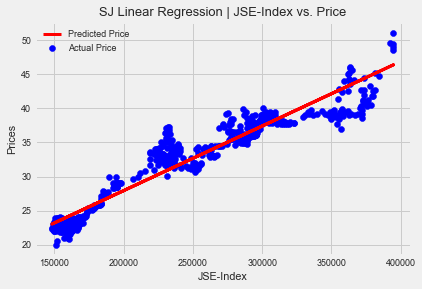

In [249]:
#Regression on Price vs Time
regressor = LinearRegression()
regressor.fit(jseindex, stock_list)
plt.rcParams.update({'font.size': 9})
plt.scatter(jseindex,stock_list, color='blue', label= 'Actual Price')
plt.plot(jseindex, regressor.predict(jseindex), color='red', linewidth=3, label = 'Predicted Price') #plotting the line made by linear regression
plt.title(sym +' Linear Regression | JSE-Index vs. Price')
plt.legend()
plt.xlabel('JSE-Index')
plt.ylabel('Prices')
plt.show()

<h3> Prediction Model Stock</h3>

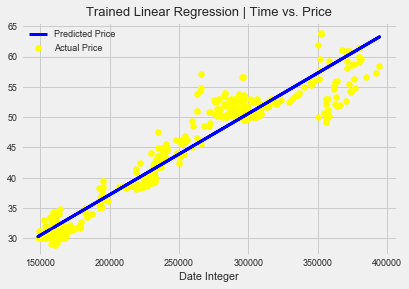

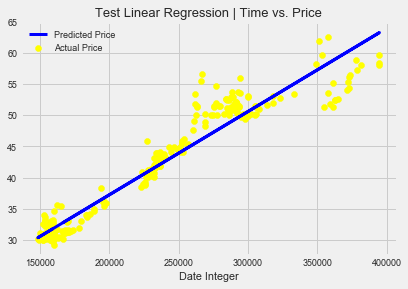

In [153]:
#Splitting the dataset into the Training set and Test set
xtrain, xtest, ytrain, ytest = train_test_split(jseindex, stock_list, test_size=0.33, random_state=42)

xtrain = np.reshape(xtrain, (len(xtrain), 1))
ytrain = np.reshape(ytrain, (len(ytrain), 1))

xtest = np.reshape(xtest, (len(xtest), 1))
ytest = np.reshape(ytest, (len(ytest), 1))

regressor.fit(xtrain, ytrain)
plt.rcParams.update({'font.size': 9})

#Train Set Graph
plt.scatter(xtrain, ytrain, color='yellow', label= 'Actual Price') #plotting the initial datapoints
plt.plot(xtrain, regressor.predict(xtrain), color='blue', linewidth=3, label = 'Predicted Price') #plotting the line made by linear regression
plt.title('Trained Linear Regression | Time vs. Price')
plt.legend()
plt.xlabel('Date Integer')
plt.show()

#Test Set Graph
plt.scatter(xtest, ytest, color='yellow', label= 'Actual Price') #plotting the initial datapoints
plt.plot(xtest, regressor.predict(xtest), color='blue', linewidth=3, label = 'Predicted Price') #plotting the line made by linear regression
plt.title('Test Linear Regression | Time vs. Price')
plt.legend()
plt.xlabel('Date Integer')
plt.show()

<h2> Calculating Portfolio </h2>

In [154]:
# Find Stock that has the same about of trade days
value = stkframe.count(axis=0)
value = value.index[stkframe.count(axis=0) == stkframe['CAR'].count()]
value

Index(['CCC', '1834', 'AFS', 'AMG', 'BIL', 'BPOW', 'BRG', 'CAR', 'CBNY',
       '138SL', 'CFF', 'CHL', 'CPJ', 'DCOVE', 'DTL', 'EPLY', 'GENAC', 'GK',
       'HONBUN', 'JAMT', 'JBG', 'JMMBGL', 'JP', 'JSE', 'KEX', 'KLE', 'KPREIT',
       'KREMI', 'KW', 'LASD', 'LASF', 'LASM', 'MDS', 'MIL', 'PAL', 'PJAM',
       'PTL', 'PULS', 'PURITY', 'ProvenJA', 'RJR', 'SALF', 'SEP', 'SGJ', 'SIL',
       'SJ', 'SRA', 'SVL', 'XFUND'],
      dtype='object')

In [155]:
#Create Porfolio by randomly selecting 6 Stocks
selectStock = []
for i in range(0,6):
    rand_indx = np.random.randint(len(value))
    selectStock.append(value[rand_indx])

selectStock = ['CAR','GWEST','JMMBGL','JSE','SCIJMD','VMIL']

In [156]:
rate_return[selectStock].describe()

,CAR,GWEST,JMMBGL,JSE,SCIJMD,VMIL
count,745.000000,251.000000,745.000000,745.000000,131.000000,247.000000
mean,0.000587,-0.002328,0.001603,-0.000944,-0.003655,0.000438
std,0.018135,0.042918,0.030033,0.072433,0.035551,0.023261
min,-0.133662,-0.211880,-0.198338,-1.609438,-0.146977,-0.068614
25%,-0.005023,-0.009723,-0.010690,-0.007722,-0.012618,-0.009841
50%,0.000000,0.000000,0.000000,0.000000,-0.000800,0.000000
75%,0.005396,0.000000,0.012251,0.007220,0.007584,0.010076
max,0.147301,0.230987,0.187460,0.375943,0.101441,0.190518


C:\Users\Romayne\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


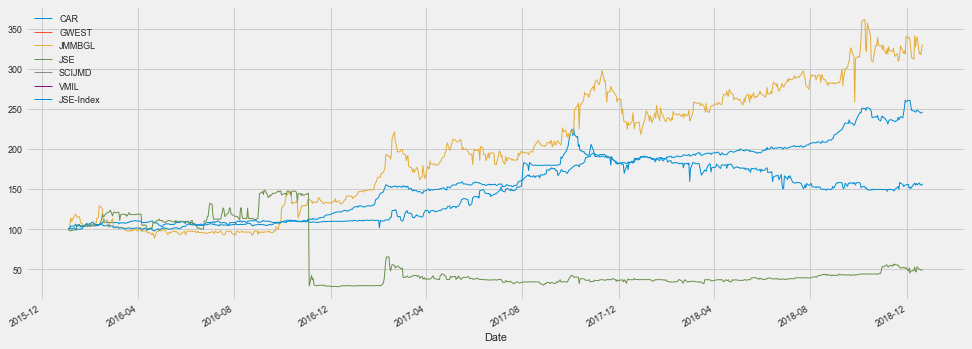

In [157]:
plt.rcParams.update({'font.size': 9})
portfolio_compare = pd.DataFrame
portfolio_compare = stkframe[selectStock]
portfolio_compare['JSE-Index'] = df_ind_data['JSE-Index']
(portfolio_compare / portfolio_compare.iloc[0] * 100).plot(figsize = (15, 6),linewidth=1);
plt.show()
#df_ind_data['JSE-Index']
#portfolio_compare[selectStock].tail()

<h3> Calculate Portfolio Rate of Return </h3>

In [158]:
#Equally weighted Portfolio
weights = np.array([0.381762259,0.005572008,0.007400742,0.027681738,0.03950554,0.538077713])

In [159]:
pfolio_rate_return = str(round(np.dot(avg_returns[selectStock], weights),5) * 100) + "%"
'Returns on Porfolio :' + pfolio_rate_return 

'Returns on Porfolio :40.193%'

<h3> Calculate Portfolio Risk </h3>

In [160]:
# Calculate the covariance of the total portfolio
portfolio_var = np.dot(weights.T, np.dot(rate_return[selectStock].cov() * 250, weights))
'Variance :' + str(round(portfolio_var,5)*100) + '%'

'Variance :5.502%'

In [161]:
#Portfolio Volatilty
portfolio_vol = np.dot(weights.T, np.dot(rate_return[selectStock].cov() * 250, weights)) ** 0.5
'Volitility :' + str(round(portfolio_vol, 3)*100) + '%' 

'Volitility :23.5%'

<h3> Markowitz Portfolio effeciency Frontier </h3>

In [162]:
(rate_return[selectStock].mean() * 250)*100,rate_return[selectStock].cov() * 250,rate_return[selectStock].corr()

(CAR       14.681140
 GWEST    -58.198048
 JMMBGL    40.076404
 JSE      -23.597411
 SCIJMD   -91.373969
 VMIL      10.944782
 dtype: float64,
              CAR     GWEST    JMMBGL       JSE    SCIJMD      VMIL
 CAR     0.082222  0.011575  0.000273  0.005188  0.002487  0.003903
 GWEST   0.011575  0.460490 -0.005446 -0.032750 -0.006055 -0.002894
 JMMBGL  0.000273 -0.005446  0.225494  0.025240  0.024168  0.016834
 JSE     0.005188 -0.032750  0.025240  1.311640 -0.037230 -0.010357
 SCIJMD  0.002487 -0.006055  0.024168 -0.037230  0.315971  0.018269
 VMIL    0.003903 -0.002894  0.016834 -0.010357  0.018269  0.135265,
              CAR     GWEST    JMMBGL       JSE    SCIJMD      VMIL
 CAR     1.000000  0.053231  0.002007  0.015799  0.014768  0.032864
 GWEST   0.053231  1.000000 -0.016668 -0.104427 -0.015809 -0.011923
 JMMBGL  0.002007 -0.016668  1.000000  0.046410  0.074540  0.094996
 JSE     0.015799 -0.104427  0.046410  1.000000 -0.137765 -0.060630
 SCIJMD  0.014768 -0.015809  0.074540 -0

In [163]:
frontier_pfolio_return = []
frontier_pfolio_vol = []
frontier_pfolio_weight = []
frontier_pfolio_sharpe = []
for x in range(0, 50000):
    ef_weights = np.random.random(len(selectStock))
    ef_weights /= np.sum(ef_weights)
    preturn = np.dot(avg_returns[selectStock]*100, ef_weights)
    pvol = np.sqrt(np.dot(ef_weights.T, np.dot(rate_return[selectStock].cov() * 250, ef_weights)))*100
    psharpe = (preturn - bondRiskFreeRate) / pvol
    #add values to list
    frontier_pfolio_return.append(preturn)
    frontier_pfolio_vol.append(pvol)
    frontier_pfolio_weight.append(ef_weights)
    frontier_pfolio_sharpe.append(psharpe)
    
frontier_pfolio_return = np.array(frontier_pfolio_return)
frontier_pfolio_vol = np.array(frontier_pfolio_vol)
frontier_pfolio_weight = np.array(frontier_pfolio_weight)
frontier_pfolio_sharpe = np.array(frontier_pfolio_sharpe)


frontier_pfolio_return[:5],frontier_pfolio_vol[:5]

(array([ 7.67694668, 14.59783276,  2.37343929, 23.84850995,  2.38145258]),
 array([24.06903173, 27.38278816, 23.16947059, 29.67630225, 32.1787488 ]))

In [164]:
frontier_pfolio_frame = pd.DataFrame({'Return':frontier_pfolio_return,'Volitile':frontier_pfolio_vol,'Sharpe':frontier_pfolio_sharpe})

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(selectStock):
    frontier_pfolio_frame[symbol+' weight'] = [weight[counter] for weight in frontier_pfolio_weight]
    
# find min Volatility & max sharpe values in the dataframe (df)
min_volatility = frontier_pfolio_frame['Volitile'].min()
max_sharpe = frontier_pfolio_frame['Sharpe'].max()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = frontier_pfolio_frame.loc[frontier_pfolio_frame['Sharpe'] == max_sharpe]
min_variance_port = frontier_pfolio_frame.loc[frontier_pfolio_frame['Volitile'] == min_volatility]

frontier_pfolio_frame=frontier_pfolio_frame.sort_values(by=['Volitile'],ascending=False)
frontier_pfolio_frame.head()

,Return,Volitile,Sharpe,CAR weight,GWEST weight,JMMBGL weight,JSE weight,SCIJMD weight,VMIL weight
45234,-13.072031,81.657795,-0.160695,0.078227,0.049951,0.009312,0.714092,0.090069,0.058349
15073,-10.541586,77.317999,-0.136987,0.014178,0.005222,0.137008,0.670604,0.104000,0.068987
40138,-8.235459,74.098183,-0.111817,0.007831,0.006888,0.164111,0.640569,0.086010,0.094590
43298,-24.217264,73.928076,-0.328255,0.004263,0.138478,0.057936,0.642555,0.135831,0.020936
1631,0.433131,73.733575,0.005196,0.074979,0.031205,0.183892,0.635867,0.012618,0.061440


In [165]:
frontier_pfolio_frame.tail()

,Return,Volitile,Sharpe,CAR weight,GWEST weight,JMMBGL weight,JSE weight,SCIJMD weight,VMIL weight
46395,32.659828,19.734318,1.652443,0.367292,0.103487,0.135828,0.006908,0.096911,0.289575
1623,31.636786,19.723201,1.601504,0.362436,0.077486,0.174668,0.022195,0.146472,0.216743
15674,30.190580,19.650887,1.533802,0.383009,0.108759,0.138586,0.046260,0.129059,0.194327
46890,34.387896,19.635055,1.748806,0.382774,0.058894,0.159341,0.051161,0.126202,0.221629
38823,37.554786,19.562931,1.917135,0.461976,0.080121,0.104097,0.029933,0.135015,0.188859


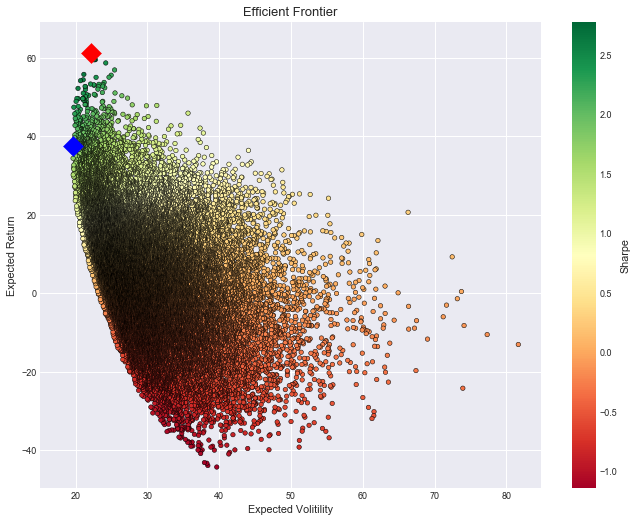

In [166]:
plt.style.use('seaborn-dark')
frontier_pfolio_frame.plot(x='Volitile',y='Return',c='Sharpe',kind='scatter',cmap='RdYlGn', edgecolors='black',
                           figsize=(10,8),grid=True);

plt.scatter(x=sharpe_portfolio['Volitile'], y=sharpe_portfolio['Return'], c='red', marker='D', s=200)
plt.scatter(x=min_variance_port['Volitile'], y=min_variance_port['Return'], c='blue', marker='D', s=200 )

plt.xlabel('Expected Volitility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.show()

In [167]:
# Red Dot portfolio with best Sharpe ratio (Best returns for risk)
sharpe_portfolio

,Return,Volitile,Sharpe,CAR weight,GWEST weight,JMMBGL weight,JSE weight,SCIJMD weight,VMIL weight
20315,61.321605,22.066189,2.776719,0.630541,0.014252,0.213249,0.028945,0.087051,0.025961


In [168]:
# Blue Dot stock with least varience / risk
min_variance_port

,Return,Volitile,Sharpe,CAR weight,GWEST weight,JMMBGL weight,JSE weight,SCIJMD weight,VMIL weight
38823,37.554786,19.562931,1.917135,0.461976,0.080121,0.104097,0.029933,0.135015,0.188859
